# Documentation for Automated Market Maker Verification Test

ACTION_LIST = [['test_add', 'test_q_for_r', 'test_r_for_r','test_r_for_q', 'test_remove']]



## Model Description

   - 1 Uniswap model with several instances that each are responsible for a particular mechanism
        - which of 1 instance is used for liquidity provision in asset $R_i$: this is modeled as a Uniswap of $R_i$ and $Q$
        - which of 1 instance is used for liquidity provision in asset $R_j$: this is modeled as a Uniswap of $R_j$ and $Q$
        - which of 1 instance is used for swaps between assets $R_i$ and $R_j$: this is modeled as a Uniswap of $R_i$ and $R_j$

## Test cases

A variety of testcases can be explored with this model resulting from a combination of the following parameters
   
   - Event: Add Liquidity, Remove Liquidity, Swap Asset, Swap Asset for Base
   - Asset: $R_i$, $R_j$, $R_k$, $Q$
   - Multiple Action Type: Alternating, $i$ only, $j$ only
   - Composite Action Type: Alternating, Trade Bias
   - Enable Symmetric Liquidity: True, False
    
In addition to these settings also a fee structure can be imposed:

   - Fixed Fee

## Test agents

The model specifies a number of eight agents that each have their local balances, can interact with the system and can be modeled to be responsible for **one action only** or as composite agents. This allows to track for each testcase how the balances will develop and to show independently which events will trigger changes to local and global states. Most importantly directly and indirectly affected variables can be easily identified.

A dataframe of agents are initialized to interact with the Uniswap instances. 




## Composite Action Tests

Besides being able to test all mechanisms individually also compositions of actions can be performed. This means selecting and combining two from the above testcases and letting the respective agents take the actions repeatedly. A composition action test therefore is defined as two actions which each can be a combination of *event* and *asset* selected from the list of testcases above, for example:
- Add liquidity in $R_i$ and Add liquidity in $R_j$
- Add liquidity in $R_i$ and Swap $R_i$ for $Q$
- Remove liquidity in $R_j$ and Swap $R_i$ for $Q$
- ...

In total there would be 28 composit pairs which can be derived from this decision tree:
selecting any one of the four primitive mechanisms of: **trade in/out** or **add/remove liquidity** of some given asset and then the subsequent action could be the three remaining mechanisms of the same asset or doing anyone of the four mechanisms in another asset.  

These basic combinations can be explored before further proceeding with
- trade sizes,
- trade frequencies,
- randomization,...



# Testcase in this notebook


This notebook documents the results of the following experiment:
- **Action 1**: One agent adds liquidity in XX
- **Action 2**: Another agent trades XX for XX.

which is a reslt of the following settings:

- exo_trade = ['test_q_for_r'] # agent 0
- exo_liq = ['test_add'] # agent 3
- exo_asset = ['alternating']
- exo_composite = ['alternating'] 

## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap (https://github.com/Uniswap/uniswap-v1/blob/master/contracts/uniswap_exchange.vy):
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

## Model File structure

The folder **model** contains:

 - a file config.py: 

    This file configures the simulation experiments by setting the number of monte carlo runs, the number of timesteps for the simulation and the simulation parameters. It also aggregates the partial states and the initial state variables.
    
    The purpose of this file is to *configure and initialize* the experiment.
    
    
 - a file partial_state_update_block.py

    This file defines each partial state update block individually. This feature allows cadCAD to divide each simulation timestep into several 'blocks' where different state variables are mutated conditioned upon the policy input.
    
    In the current setting 
    - the first block maps the user action to the appropriate mechanism in the uniswap world
    - the second block calculates the metrics: the swap prices in the uniswap instances

    This file corresponds to the system specification diagram, where each column is one partial state update block 
    
    The purpose of this file is to *define* the sequence and details of state updates for each simulation timestep. The relevant mechanisms are imported from the files in the **parts** folder
    
       

 - a file run.py

    This file *defines* the run and postprocessing methods and is used to execute the simulation run:
    - run() is used to execute the simulation and create a dataframe
    - postprocessing is used to extract relevant metrics from the simulation output in the dataframe

     The purpose of this file is to *execute* the simulation and *create* metrics.
     
     
 - a file state_variables.py

    This file *sets* the number of agents and *defines* the local (agent-level) state variables, *sets* the number of assets and *defines* the global (system-state) variables of the system, *computes* the prices of the assets and *defines* the initial state object
    - the agent states describe their holdings of assets that agents have contributed to the liquidity pool or still hold outside as well as their quantities of shares they received for their contribution
    - the global states describe the quantities of assets in the system
    - price variables are computed from the states in the uniswap instances
    - the initial state object consists of 
        - agent dataframe
        - a set of global variables, one for each Uniswap instance
        - prices

    The purpose of this file is to *define* the global and local states of the system.
    
    
 - a file sys_params.py

    This file *contains* the system parameters and allows to select items from a list for them. Following parameters can be defined:
    - trade action type
    - liquidity action type
    - multiple asset action type
    - composite action type
    - liquidity add type (symmetry)

    In addition the following is set
    - initial values for assets 
    - hard coded fee value
    - choice of the system parameters from the list above
    

 - a folder **parts** which itself contains general files relevant for both instances, files related specifically to Uniswap
      - [action.py](model/parts/action.py)
       This is an action dictionary which drives the model. As there are no behavioral assumptions in the model yet, currently actions are prescribed actions in testing mode derived from events. However, action schema respects https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange as much as possible, allowing for future analysis against uniswap transaction datasets.
        This file contains a function called 'actionDecoder' which takes its inputs from the file sys_params.py and maps those encoded events to agent actions. At first an arbitrary action dictionary is defined which then is adapted according to the choices of system parameters. In particular relevant are the parameter definitions of the asset, the composite and whether there is a trade or liquidity event defined.
        
    - [uniswap.py](model/parts/uniswap.py)
     Reads in action output and directs the action to the appropriate Uniswap mechanism for each corresponding Uniswap instance. Currently there are two instances in place, namely the R_i<>Q pair and the R_j<>Q pair. Both instances have their respective requisite state variables: UNI_Qx, UNI_Rx, and UNI_Sx.

    - [utils.py](model/parts/utils.py)
    Computes the state update for each Uniswap state variable and outputs the updated global state variables.
        
     - [agent_utils.py](model/parts/agent_utils.py)
     Computes the corresponding agent local state for each Uniswap agent resolving their action and outputs the updates local state variables.




## Run Model

The following command lines import all packages, experiments and run the model 

This is the execution of cadcad. This writes the config object, does the execution and returns the rdf - which is a data object that shows the rows and columns of results in a dataframe

Here is one additional option as well. The postprocessing causes the index of the results to be every forth because of the cadcad architecture where the partial state updates are the substeps. With this option selected we see only the end of each timestep - the last substep. Therefore only final results are shown. To get a line for each substep the postprocessing needs to be deactivated. 

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Experiments
from model import run
from model.parts.utils import *
from model.plot_utils import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

df = run.run()
rdf = run.postprocessing(df)
# rdf = df # debugging substeps
# pd.set_option("mode.chained_assignment", None)



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 12, 1, 13)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 12, 1, 13)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec
Execution Mode: single_threaded


/Users/andrewclark/repos/demos/demos/Multiscale/amm_mechanism/model/parts/agent_utils.py:153: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  U_agents.at[agent_id,'r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id + '_out'] - delta_Ri
/Users/andrewclark/repos/demos/demos/Multiscale/amm_mechanism/model/parts/agent_utils.py:154: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  U_agents.at[agent_id,'r_' + purchased_asset_id + '_out'] = chosen_agent['r_' + purchased_asset_id + '_out'] + delta_Rk
/Users/andrewclark/repos/demos/demos/Multiscale/amm_mechanism/model/parts/agent_utils.py:153: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  U_agents.at[agent_id,'r_' + asset_id + '_out'] = chosen_agent['r_' + asset_id

Flattening results:   0%|          | 0/2001 [00:00<?, ?it/s]

Total execution time: 0.27s


## Interpretation of Results

### Creation of Results

Before moving to the interpretation and analysis we first create and prepare the results: sometimes just to see whether the experiment is running corectly and sometimes to see into the results for analysis

The following command lines creates views based on the simulation results.

- the `model_history`, counting for the i-th base asset, the asset and the shares of the asset respectively.
- the `uniswap_j`, counting for the j-th base asset, the asset and the shares of the asset respectively.,
- the `uniswap_ij` counting for the i-j asset, the asset and the shares of the asset respectively


In [2]:
model_history = rdf[['UNI_Qi', 'UNI_Ri', 'UNI_Si']]
model_history.columns = ['model_UNI_Qi', 'model_UNI_Ri', 'model_UNI_Si']

uniswap_j = rdf[['UNI_Qj', 'UNI_Rj', 'UNI_Sj']]
uniswap_j.columns = ['UNI_Qj', 'UNI_Rj', 'UNI_Sj']

uniswap_ij = rdf[['UNI_ij', 'UNI_ji', 'UNI_Sij']]
uniswap_ij.columns = ['UNI_ij', 'UNI_ji', 'UNI_Sij']


### Representing results in table form

The simulation results and variable quantities can be shown in table form where

- `head(n)`
- `tail(n)`

can be used to target the $n$ specific entries.

##### The columns show:
##### for the uniswap universe
- `UNI_Qi`...the quantity of the Q-th assets
- `UNI_Ri`...the quantity of the i-th assets
- `UNI_Si`...the quantity of the i-th assets shares
- `UNI_Qj`...the quantity of the Q-th assets
- `UNI_Rj`...the quantity of the j-th assets
- `UNI_Sj`...the quantity of the j-th assets shares
- `uni_agents`...the definition of the actions of the uniswap agents
- `UNI_P_RQi`...the price of the i-th asset in terms of Q
- `UNI_P_RQj`...the price of the j-th asset in terms of Q

##### simulation parameters
- `simulation`...simulation number
- `subset`...subset number
- `run`...run number
- `substep`...substep number
- `timestep`...timestep of simulation

In [3]:
rdf.head(5)

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,UNI_ij,UNI_ji,UNI_Sij,uni_agents,UNI_P_RQi,UNI_P_RQj,UNI_P_ij,simulation,subset,run,substep,timestep
2,1998008,1001000,10000,2000000,1000000,10000,1000000,1000000,1000000000000,m r_i_out r_i_in h q_i s_i ...,2.00,2.01,1.00,0,0,1,2,1
4,1998008,1001000,10000,2001000,999502,10000,1000000,1000000,1000000000000,m r_i_out r_i_in h q_i s_i ...,2.00,2.01,1.00,0,0,1,2,2
6,2097809,1051000,10499,2001000,999502,10000,1000000,1000000,1000000000000,m r_i_out r_i_in h q_i ...,2.00,2.01,1.00,0,0,1,2,3
8,2097809,1051000,10499,1999006,1000502,10000,1000000,1000000,1000000000000,m r_i_out r_i_in h q_i ...,2.00,2.01,1.00,0,0,1,2,4
10,2098809,1050501,10499,1999006,1000502,10000,1000000,1000000,1000000000000,m r_i_out r_i_in h q_i ...,2.01,2.01,1.00,0,0,1,2,5


In [4]:
rdf.tail()

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,UNI_ij,UNI_ji,UNI_Sij,uni_agents,UNI_P_RQi,UNI_P_RQj,UNI_P_ij,simulation,subset,run,substep,timestep
1992,1866556,1072254,9999,1859031,1076754,10000,1008231,992059,1000000000000,m r_i_out r_i_in h q_i ...,1.75,1.73,1.02,0,0,1,2,996
1994,1864823,1073254,9999,1859031,1076754,10000,1008231,992059,1000000000000,m r_i_out r_i_in h q_i ...,1.75,1.73,1.02,0,0,1,2,997
1996,1864823,1073254,9999,1860031,1076177,10000,1008231,992059,1000000000000,m r_i_out r_i_in h q_i ...,1.75,1.74,1.02,0,0,1,2,998
1998,1864823,1073254,9999,1860031,1076177,10000,1008331,991961,1000000000000,m r_i_out r_i_in h q_i ...,1.75,1.74,1.02,0,0,1,2,999
2000,1864823,1073254,9999,1858310,1077177,10000,1008331,991961,1000000000000,m r_i_out r_i_in h q_i ...,1.75,1.73,1.02,0,0,1,2,1000


# The pools and global states

## Global State variables for Uniswap
## i - Q instance
### Quantities of i-th asset, the Q asset and the i-asset shares

The following command lines **create three plots** that show: (for the i-th asset)
- on the left: the quantity of base asset `model_UNI_Qi` 
- center: the quantity of asset `model_UNI_Ri` 
- on the right: the quantity of shares `model_UNI_Si`
over all simulation steps

To show other assets the suffix of these commands can be replaced by f.e. `Qj` instead of `Qi`

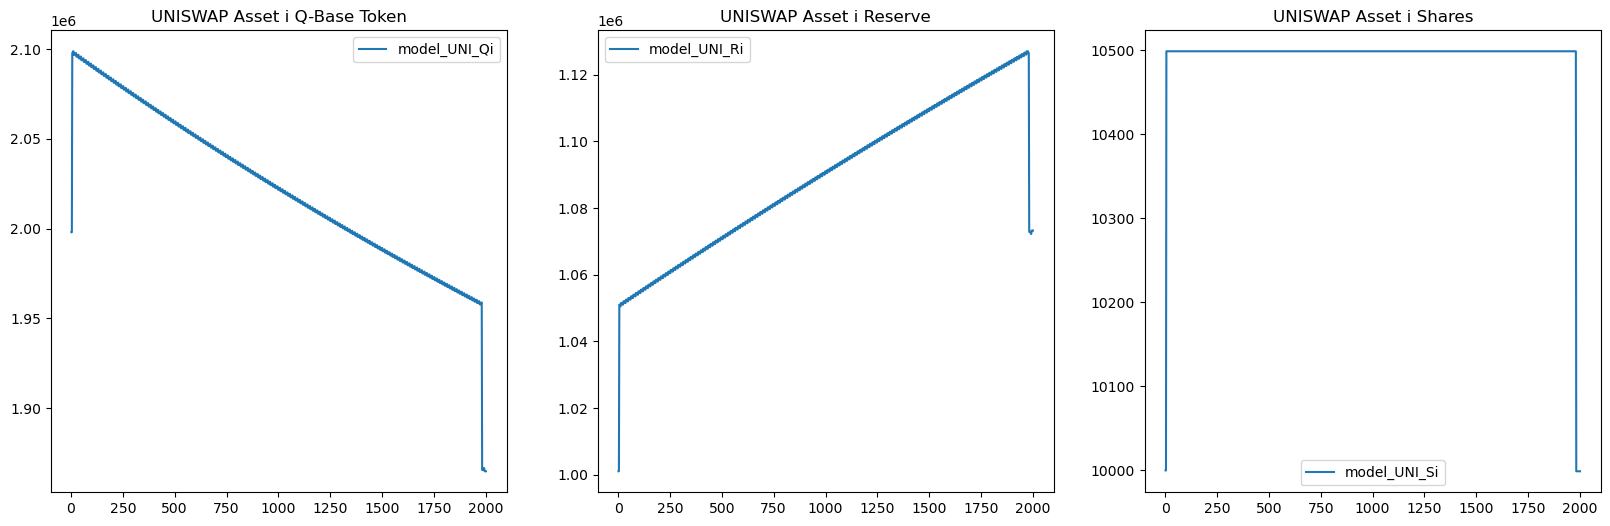

In [5]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Qi'])
plt.title('UNISWAP Asset i Q-Base Token')

ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Ri'])
plt.title('UNISWAP Asset i Reserve')

ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Si'])
plt.title('UNISWAP Asset i Shares')
plt.show()

### Prices of the i-th asset

The following command line creates a plot of the prices: (for the i-th asset)
- the swap price of the asset 
- the pool ratio price of the asset

Comparison of both plots shows the effects of fees.

For experiments where the price of the asset is affected - for example when it is traded - we expect this price either to rise or fall accordingly. For liquidity adds this price should remain unchanged.

To show other assets the suffix of these commands can be replaced by f.e. `Qj` instead of `Qi`

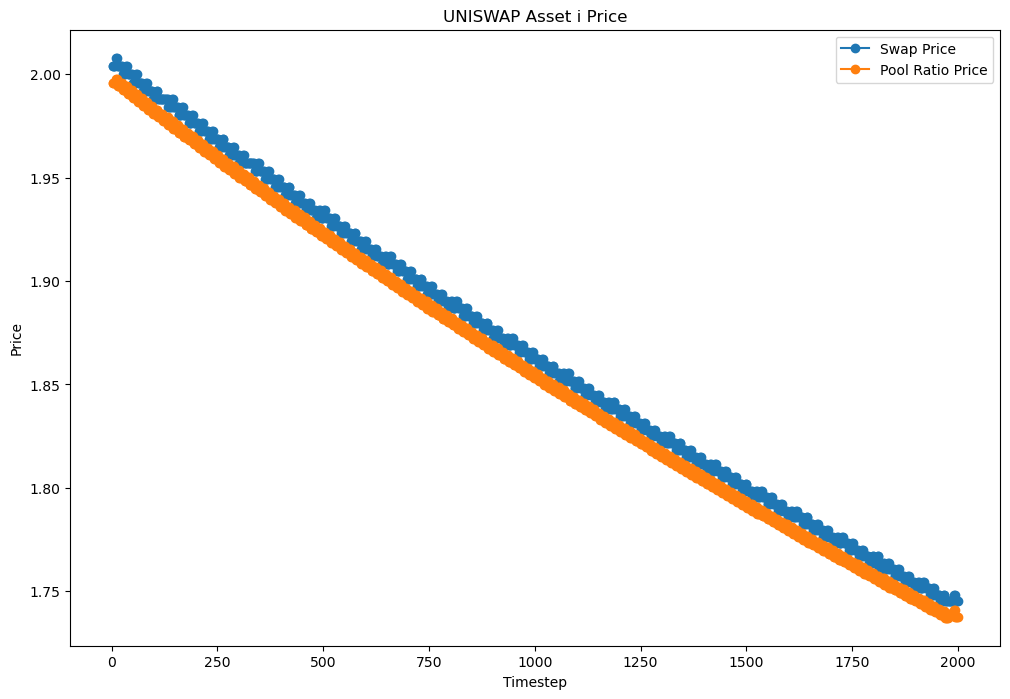

In [6]:
price_plot(rdf,'UNISWAP Asset i Price', 'UNI_P_RQi', 'UNI_Ri', 'UNI_Qi')

## j - Q instance
### Quantities of j-th asset, the Q asset and the j-asset shares


The following command lines create three plots that show: (for the j-th asset)
- on the left: the quantity of base asset `UNI_Qj` 
- center: the quantity of asset `UNI_Rj`
- on the right: the quantity of shares `UNI_Sj`

over the simulation steps

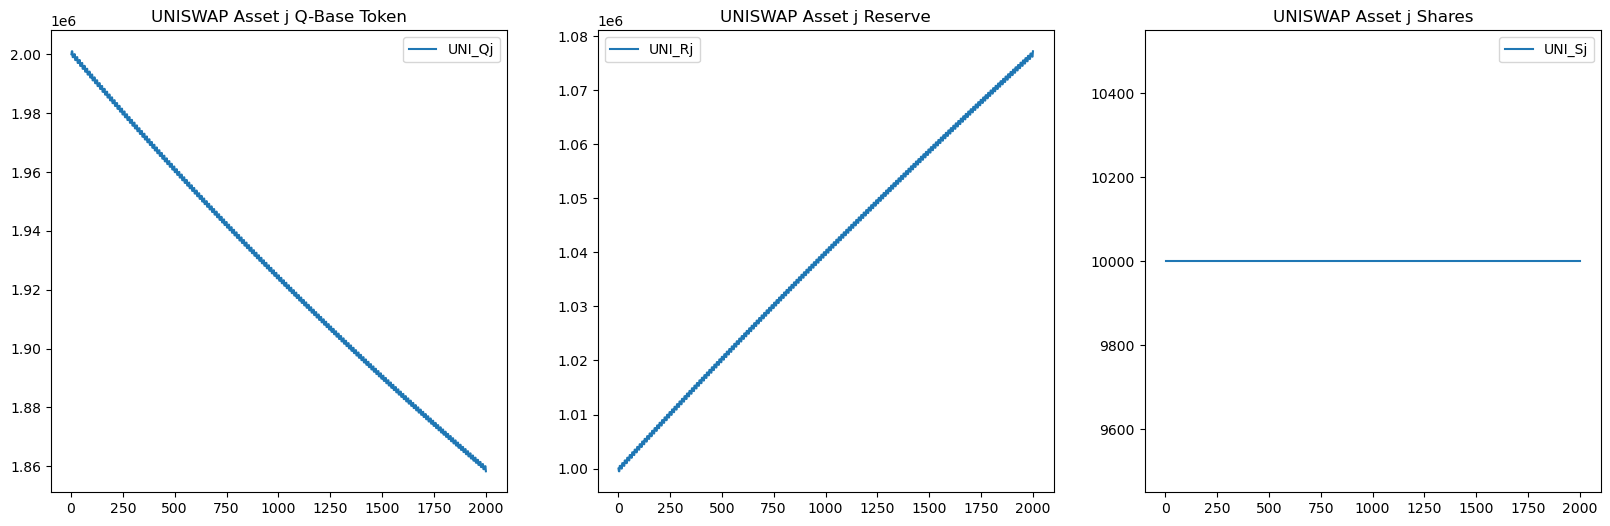

In [7]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Qj'])
plt.title('UNISWAP Asset j Q-Base Token')

ax = plt.subplot(132)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Rj'])
plt.title('UNISWAP Asset j Reserve')

ax = plt.subplot(133)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Sj'])
plt.title('UNISWAP Asset j Shares')
plt.show()

### Prices of the j-th asset

The following command line creates a plot of the prices: (for the j-th asset)
- the swap price of the asset 
- the pool ratio price of the asset

Comparison of both plots shows the effects of fees.

For experiments where the price of the asset is affected - for example when it is traded - we expect this price either to rise or fall accordingly. For liquidity adds this price should remain unchanged.

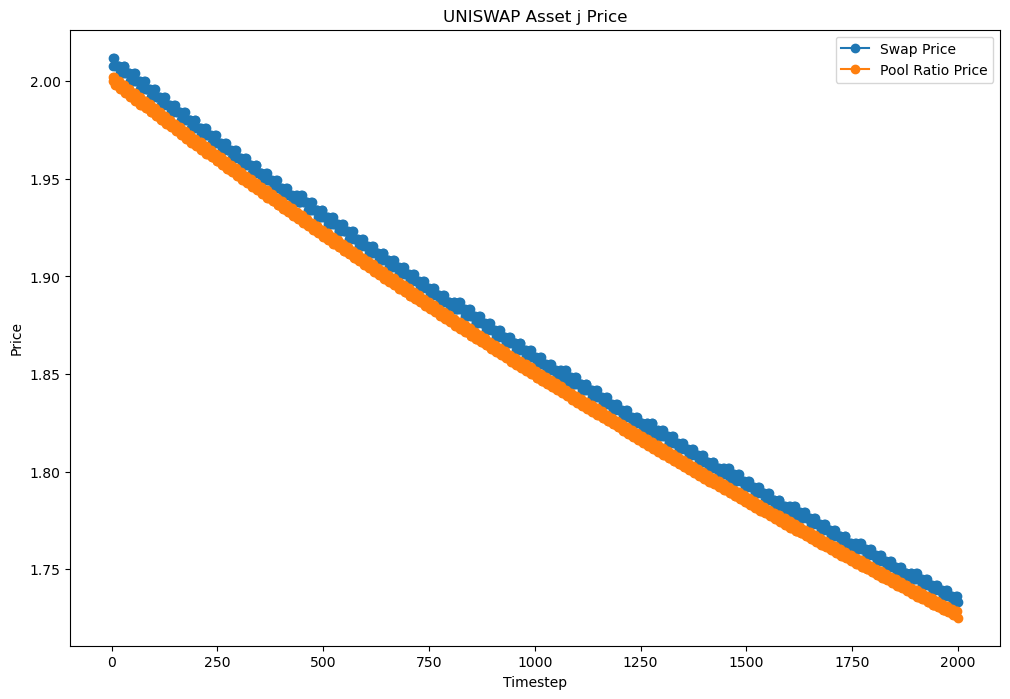

In [8]:
price_plot(rdf,'UNISWAP Asset j Price', 'UNI_P_RQj', 'UNI_Rj', 'UNI_Qj')

## i-j instance
### Quantities of i-th asset, the j-th asset and the i-j-asset shares


The following command lines create three plots that show: (for the j-th asset)
- on the left: the quantity of the i-th asset `UNI_ij` 
- center: the quantity of the j-th asset `UNI_ji`
- on the right: the quantity of i-j-shares `UNI_Sij`

over the simulation steps

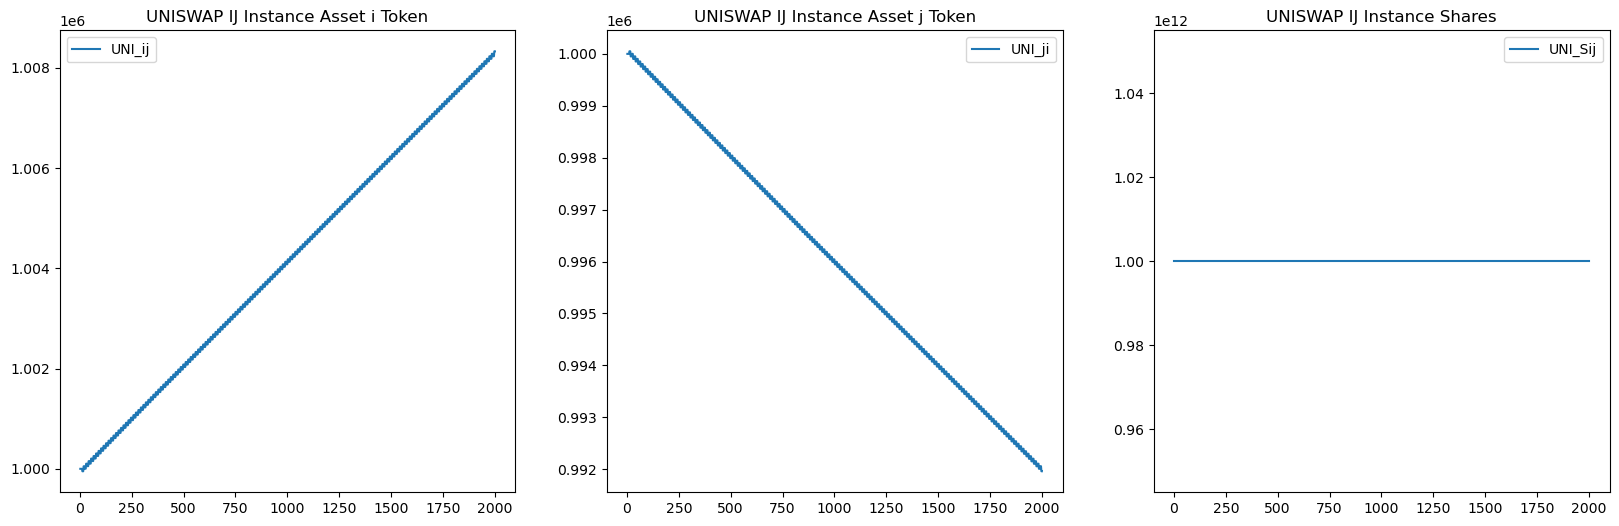

In [9]:
plt.figure(figsize=(20,6))
ax = plt.subplot(131)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_ij'])
plt.title('UNISWAP IJ Instance Asset i Token')

ax = plt.subplot(132)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_ji'])
plt.title('UNISWAP IJ Instance Asset j Token')

ax = plt.subplot(133)
uniswap_ij.astype(float).plot(ax=ax, y=['UNI_Sij'])
plt.title('UNISWAP IJ Instance Shares')
plt.show()

### Prices of the i-j asset swap

The following command line creates a plot of the swap prices
- the swap price of the asset 
- the pool ratio price of the asset

Comparison of both plots shows the effects of fees.

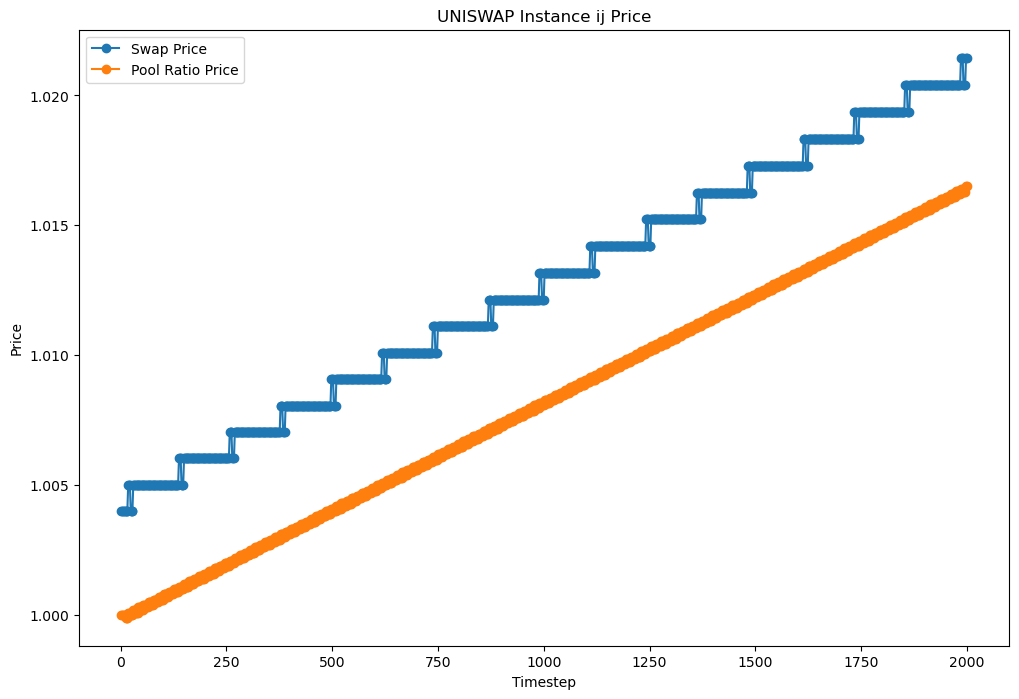

In [10]:
price_plot(rdf,'UNISWAP Instance ij Price', 'UNI_P_ij', 'UNI_ji','UNI_ij' )


# Agents and their Local State Variables

The following section tracks the development for the agent states.
As every agent is defined to be responsible for a different action and all agent states are shown this section can be used to assess 
- the intentional changes in the local states directly affected by the actions, and
- the unintentional changes in local states of other agents who are indirectly affected

All agents carry the following local states:

| Symbol | Name | Definition  | Domain |   | Unit
| -------- | -------- | -------- | -------- | -------- | --------|
| $\mathbf{r}^j$     | Reserve Assets     | Reserve Assets are quantities of privately held assets by liquidity provider agent $j$ which are not (yet) related to the Liquidity Pool. |  $\mathbb{R}_{+}^{n}$| | BTC, ETH, DOT,...; an amount in real non-negative numbers denoted in the respective currency unit
| $h^j$     | Base Asset     | Total Base Asset (HDX) amount of $H$ held by agent $j$. |  $\mathbb{R}_{+}$| | a real non-negative amount of HDX |
| $\mathbf{s}^j$     | Asset Shares     | Asset Share as value of liquidity provider agent $j$'s contribution of asset(s) to the Liquidity Pool, minted and distributed (as a claim) to agent $j$ at the time of introduction into the Pool.| $\mathbb{R}_{+}^{n}$  | |a vector of amounts in real non-negative numbers
| $s^{qj}$     | Base Asset Share     | Base Asset (HDX) share as value of liquidity provider agent $j$'s contribution of HDX to the Liquidity Pool,  minted and distributed to agent $j$ (as a claim) at the time of introduction into the Pool.| $\mathbb{R}_{+}$  | |a real non-negative number

To locate specific values in the dataframe the commands
- `first_valid_index()`
- `first_valid_index()*x`
- `last_valid_index()`

can be used.


## Uniswap world

Results for the agents are stored in `uni_agents`

In [11]:
rdf['uni_agents'][rdf.first_valid_index()]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
1,1,99000,100000,101992,100000,100000,0,100000,100000,100000,100000
2,2,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
3,3,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
4,4,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
5,5,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
6,6,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
7,7,100000,100000,100000,100000,100000,0,100000,100000,100000,100000


In [12]:
rdf['uni_agents'][rdf.first_valid_index()*2]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,100000,99000,100000,100000,0,100498,100000,100000,100000
1,1,99000,100000,101992,100000,100000,0,100000,100000,100000,100000
2,2,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
3,3,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
4,4,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
5,5,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
6,6,100000,100000,100000,100000,100000,0,100000,100000,100000,100000
7,7,100000,100000,100000,100000,100000,0,100000,100000,100000,100000


In [13]:
rdf['uni_agents'][rdf.first_valid_index()*3]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0,100000,100000,99000.00,100000.00,100000,0,100498,100000,100000,100000
1,1,99000,100000,101992.00,100000.00,100000,0,100000,100000,100000,100000
2,2,50000,150000,199.40,199800.60,100499,0,100000,100000,100000,100000
3,3,100000,100000,100000.00,100000.00,100000,0,100000,100000,100000,100000
4,4,100000,100000,100000.00,100000.00,100000,0,100000,100000,100000,100000
5,5,100000,100000,100000.00,100000.00,100000,0,100000,100000,100000,100000
6,6,100000,100000,100000.00,100000.00,100000,0,100000,100000,100000,100000
7,7,100000,100000,100000.00,100000.00,100000,0,100000,100000,100000,100000


## Agent Token Holdings - Uniswap World


The following command line creates eight plots, one for each agent individually, showing his token holdings 


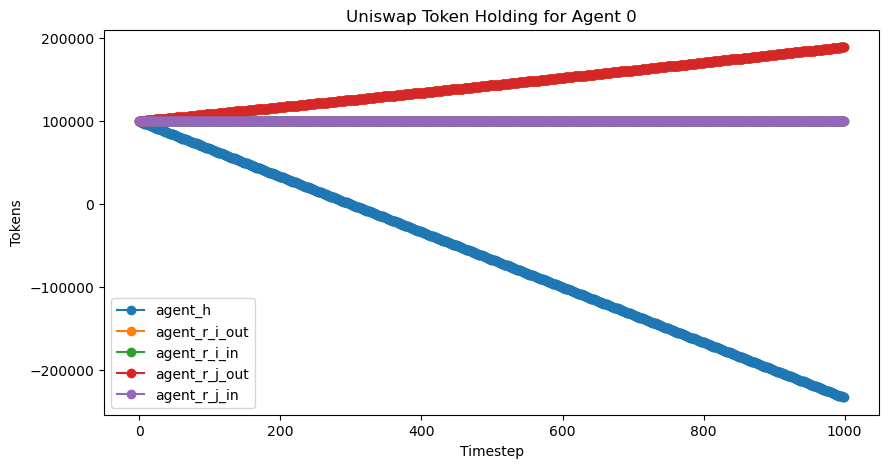

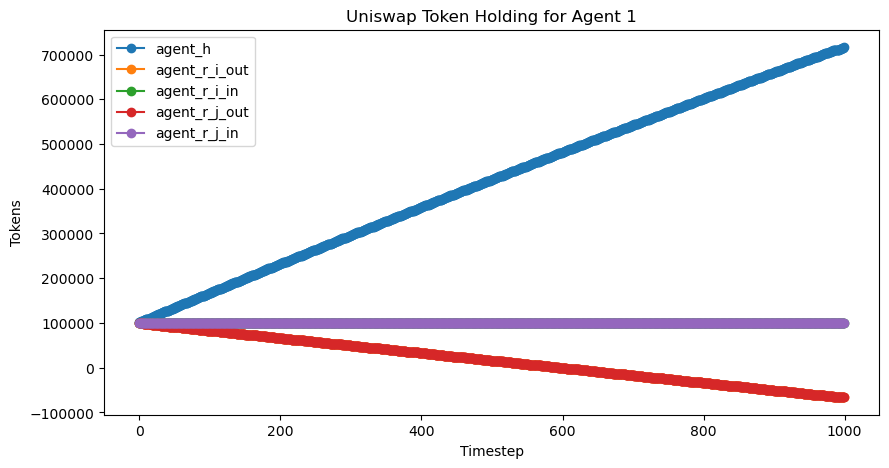

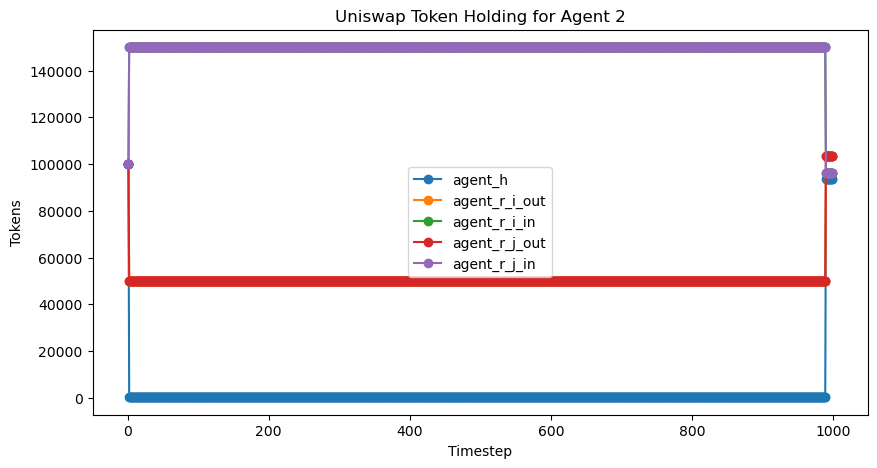

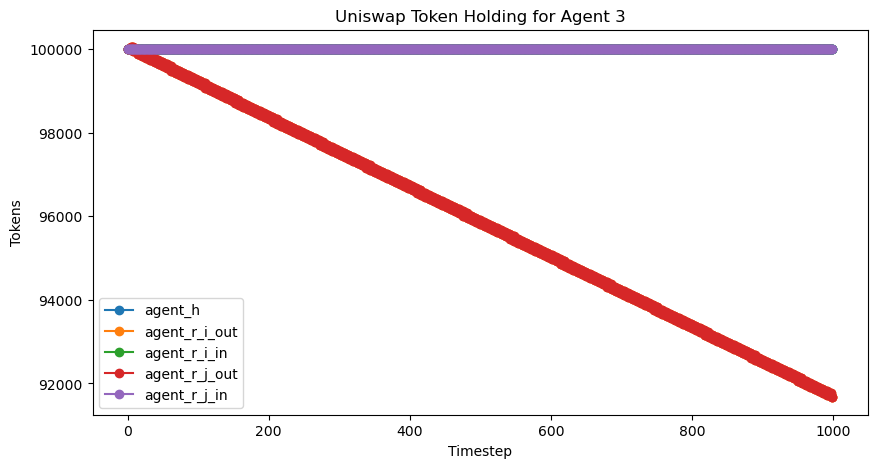

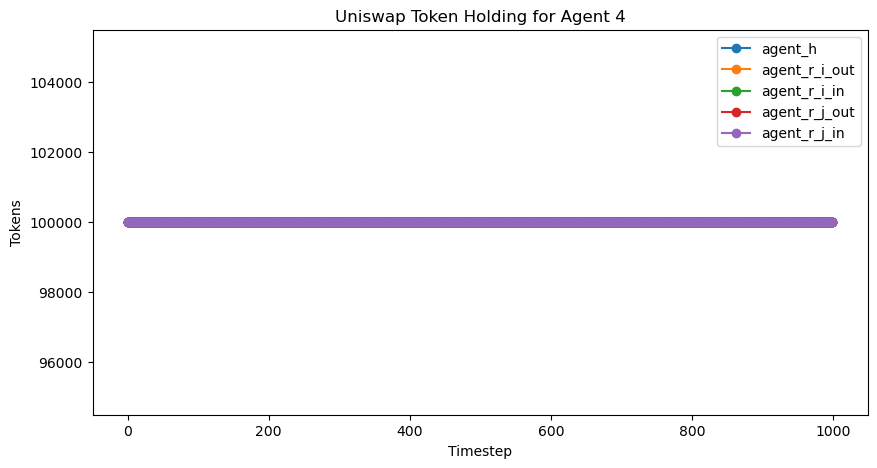

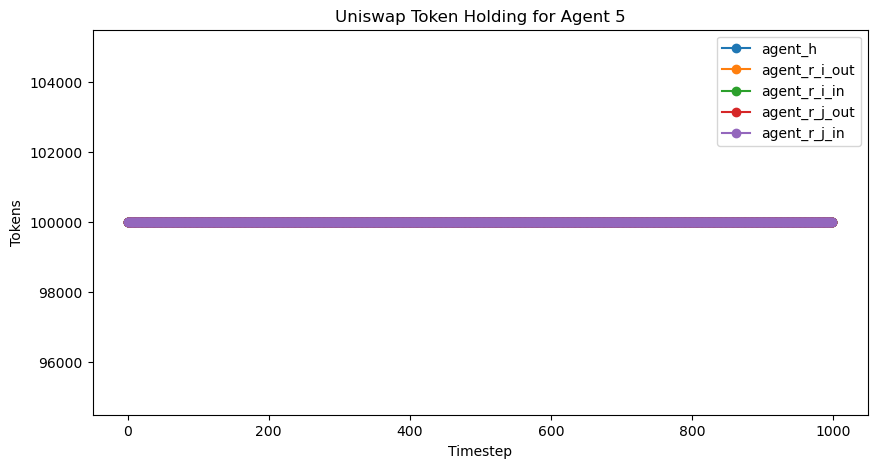

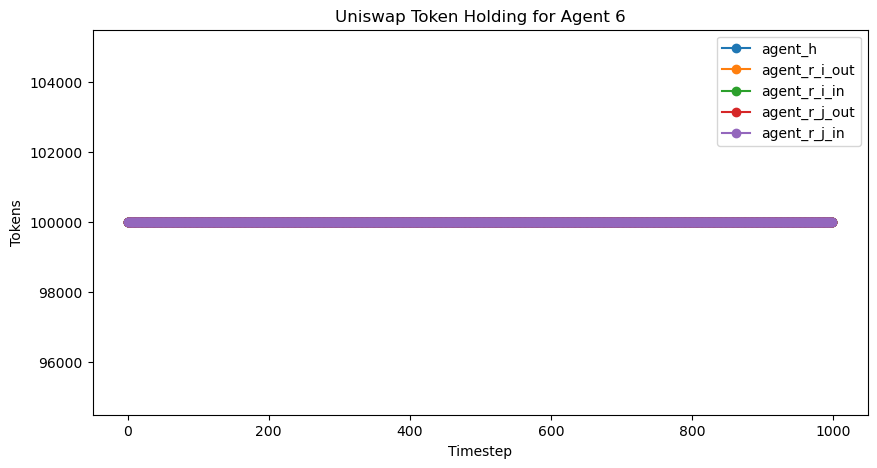

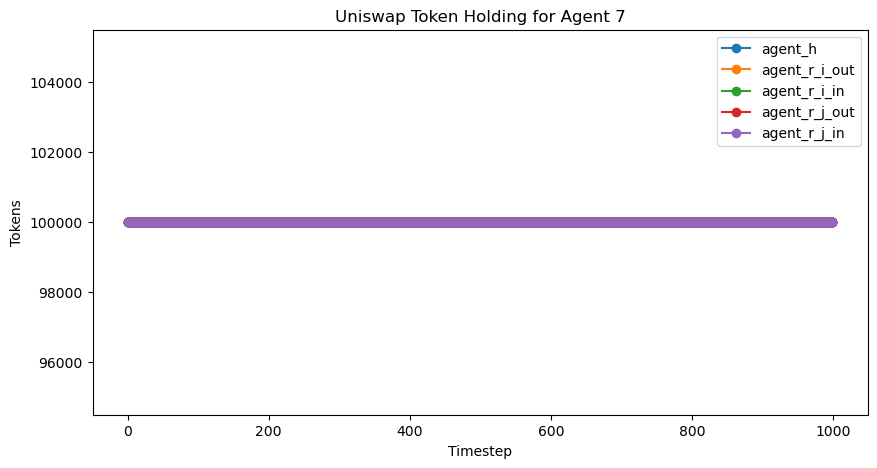

In [14]:
agent_plot(rdf,'Uniswap Token Holding for Agent ', len(rdf['timestep'])) #,4,'j')

## Agent Values - Uniswap World

The following command line creates eight plots, one for each agents showing his values. These are the token holdings multiplied by price.
  



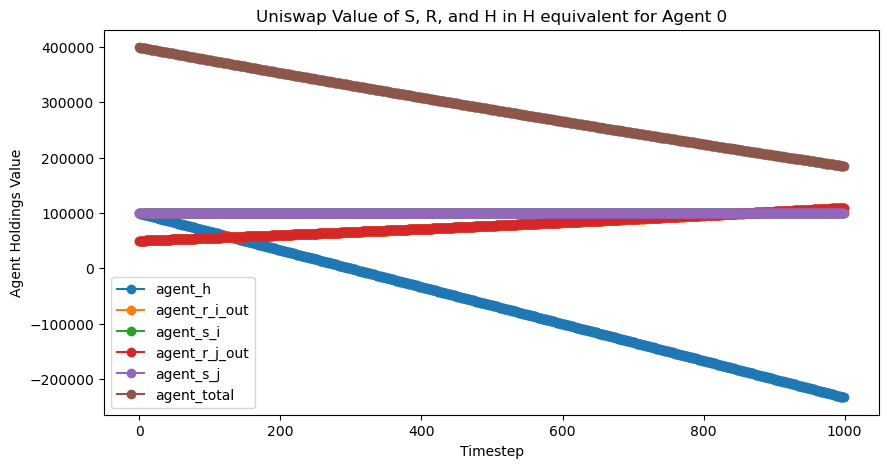

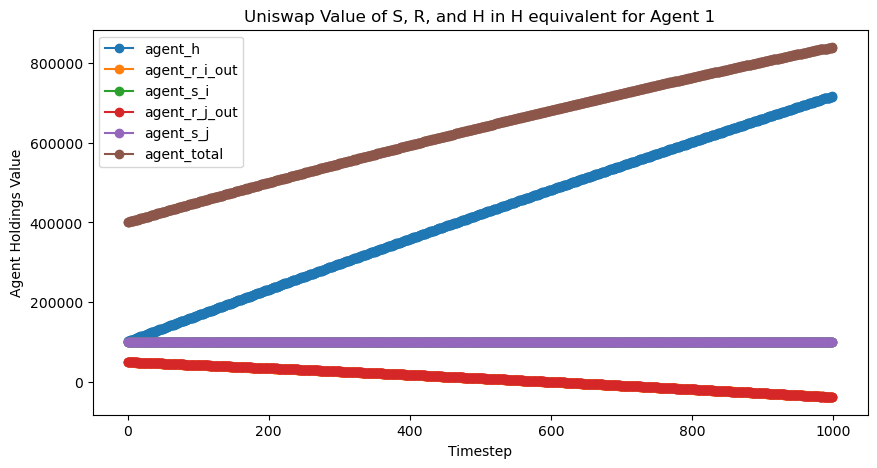

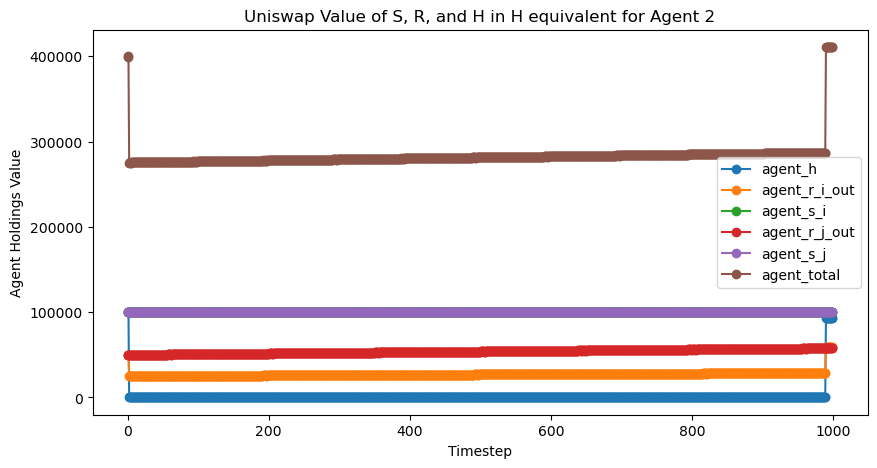

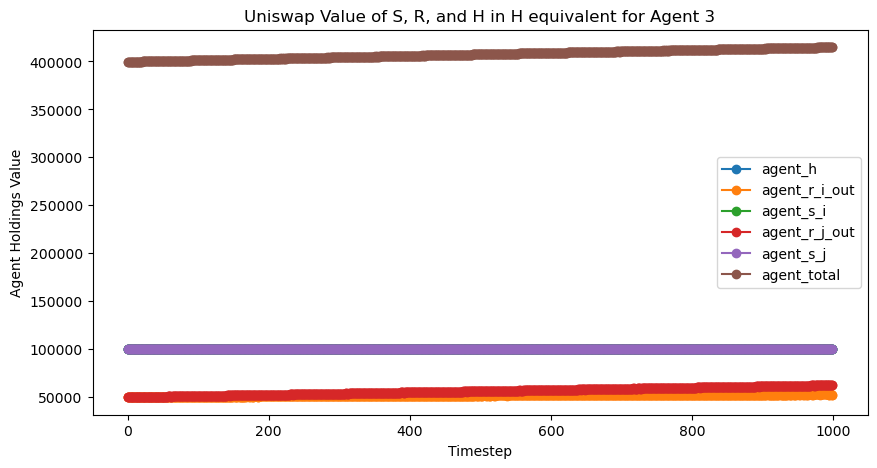

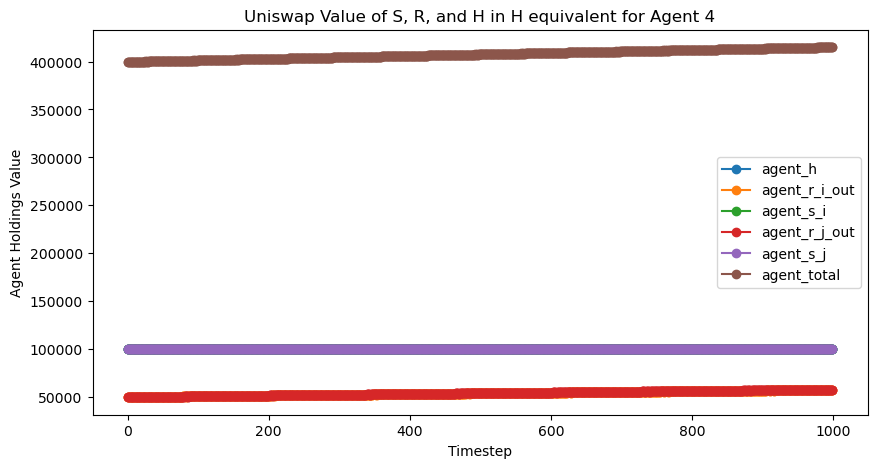

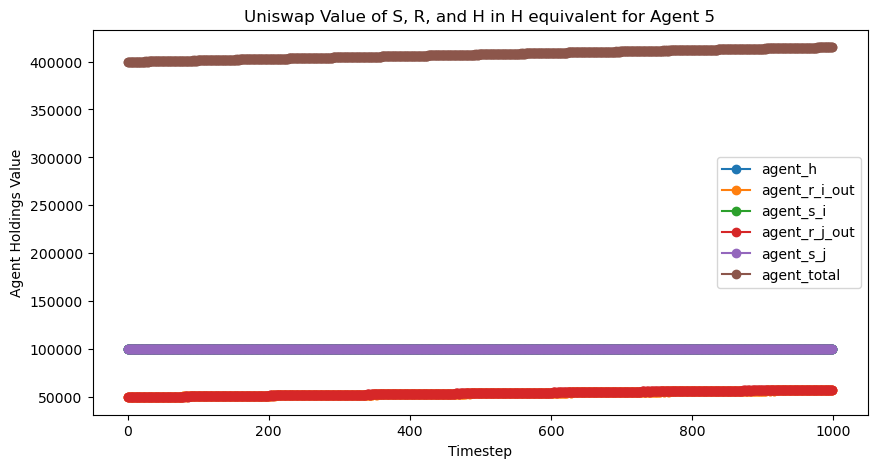

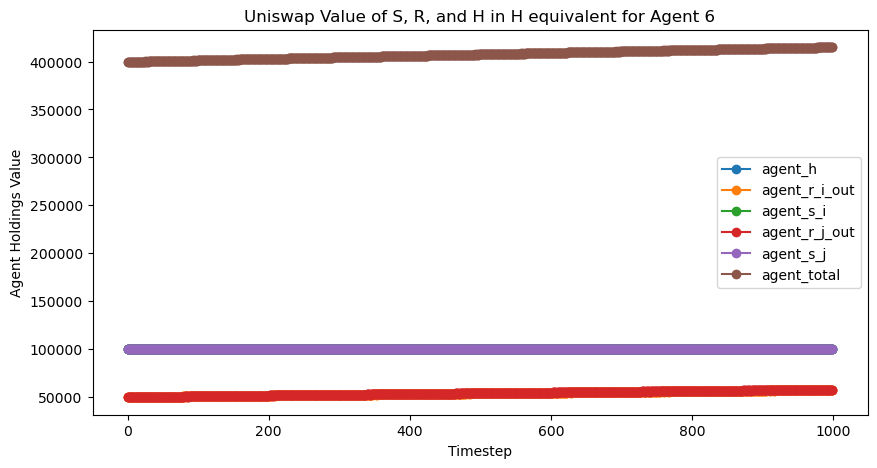

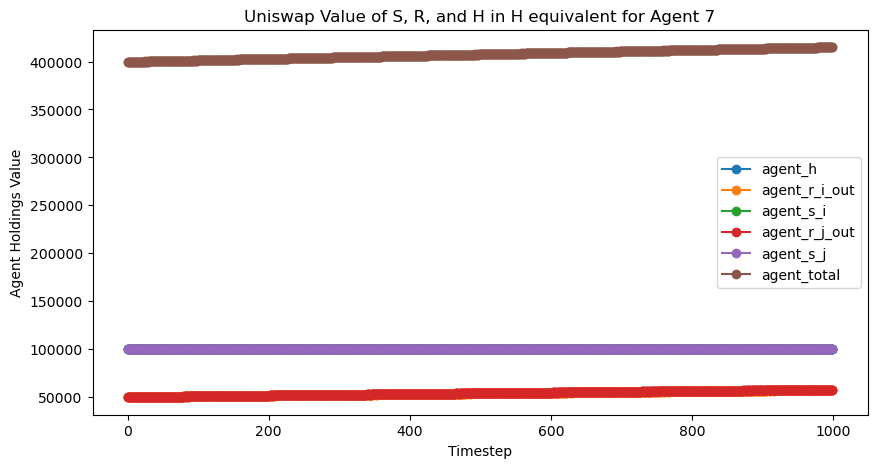

In [15]:
agent_value_plot(rdf,'Uniswap Value of S, R, and H in H equivalent', len(rdf['timestep'])) #,2, 'i')